# Assignment 1: This is the title of the assignment

Authors:  
Shayan Paydar Darian and 
Daniel Pazirai 


## Imports

In [1]:
# It is recommended to start with general import statements
from utility_functions import *
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForTokenClassification
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support

c:\Users\Shayan\anaconda3\envs\swedish-ner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [2]:
# Load the Swedish Medical NER dataset
import pandas as pd

df_1177 = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/1177/train-00000-of-00001.parquet")

df_lt = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/lt/train-00000-of-00001.parquet")

df_wiki = pd.read_parquet("hf://datasets/community-datasets/swedish_medical_ner/wiki/train-00000-of-00001.parquet")

combined_df = pd.concat([df_1177, df_lt, df_wiki], ignore_index=True)

print(df_1177.head)
print(df_lt.head)
print(df_wiki.head)

<bound method NDFrame.head of           sid                                           sentence  \
0      1177_0  Memantin ( Ebixa ) ger sällan några biverkningar.   
1      1177_1  Det är också lättare att dosera [ flytande med...   
2      1177_2  ( Förstoppning ) är ett vanligt problem hos äl...   
3      1177_3  [ Medicinen ] kan också göra att man blöder lä...   
4      1177_4  Barn har större möjligheter att samarbeta om d...   
..        ...                                                ...   
922  1177_922  Ofta kan man ha flera besvär i olika delar av ...   
923  1177_923  Vaccinationen ger inte ett fullständigt skydd ...   
924  1177_924  Vissa personer kan märka av klara förbättringa...   
925  1177_925  ( Demens ) innebär dels problem med minnet och...   
926  1177_926                                                      

                                              entities  
0    {'start': [9], 'end': [18], 'text': ['Ebixa'],...  
1    {'start': [32], 'end': [52], 'text

#### Based on the headers, the data appears to not be tokenized (which we need to do to train the model)

## Save the raw data

In [3]:
print(df_1177.info())
print(df_lt.info())
print(df_wiki.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sid       927 non-null    object
 1   sentence  927 non-null    object
 2   entities  927 non-null    object
dtypes: object(3)
memory usage: 21.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745753 entries, 0 to 745752
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sid       745753 non-null  object
 1   sentence  745753 non-null  object
 2   entities  745753 non-null  object
dtypes: object(3)
memory usage: 17.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48720 entries, 0 to 48719
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sid       48720 non-null  object
 1   sentence  48720 non-null  object
 2   entities  48720 non-null  object
dtypes: obj

## Task 1: Survey (kolla upp vilka modeller som finns och kolla vilken LLN som är bäst för Swedish Biomedical NER)

## Survey of Models for Swedish Biomedical NER

| **Model**        | **Language(s)** | **Strengths**                                   | **Weaknesses**                                  | **Relevance for Biomedical NER (Swedish)**               |
|------------------|-----------------|-------------------------------------------------|-------------------------------------------------|----------------------------------------------------------|
| **KB-BERT**      | Swedish         | Native Swedish, decent at general NER tasks     | No biomedical pretraining                       | Good starting point                                      |
| **Swedish ALBERT** | Swedish       | Lightweight, faster to train                    | Lacks domain specialization                    | OK, but may miss nuances                                 |
| **mBERT**        | Multilingual    | Cross-lingual abilities                         | Not optimized for any specific language/domain | Medium                                                   |
| **XLM-RoBERTa**  | Multilingual    | Robust multilingual understanding               | Same as mBERT, no biomedical specialization    | Medium                                                   |
| **BioBERT (English)** | English    | Biomedical domain specialized                   | Needs translated data, loses Swedish nuances   | Very good if translation is perfect                      |
 
 The survey results are based on searches on HuggingFace and google scholar with keywords (Swedish NER, Biomedical NER, etc), in order to see what models there are and what models have been used before.


## Approach and Motivation
In our approach, we want to use a Swedish Language-Model rather than translating the existing data into English. Although models like BioBERT offer very good performance in biomedical NER tasks, translation of clinical text can introduce errors and result in a loss of contextual information. This is particularly risky in the biomedical domain, where subtle differences in terminology can significantly impact the meaning of text. Additionally, as we are not biomedical experts, manually validating translations would be challenging.

Therefore, our approach is to fine-tune an existing Swedish model for biomedical NER, using the Swedish Medical NER dataset provided. 

The three models found on HuggingFace which were relevant were: 

bert-base-swedish-cased (v1) - A BERT trained with the same hyperparameters as first published by Google.

bert-base-swedish-cased-ner (experimental) - a BERT fine-tuned for NER using SUC 3.0.

albert-base-swedish-cased-alpha (alpha) - A first attempt at an ALBERT for Swedish.

## Our Choice
Out of of these models, we will be using the base model (bert-base-swedish-cased (v1)). Although the experimental version is fine tuned for NER, we want to train it on specifically biomedical NER. The base model will be perfect for that since it's flexible and gives us more control of fine tuning it and has less prior bias. We will also not use the Albert version since it's a first attempt at it and still in alpha.

Link for the KB bert models: https://huggingface.co/KB/bert-base-swedish-cased-ner 

Study which used KB/bert-base-swedish-cased and
bert-base-multilingual-cased: (Although not related to biomedicine) https://aclanthology.org/2024.caldpseudo-1.7.pdf 

We will also load an autotokenizer to tokenize the dataset.

In [4]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="KB/bert-base-swedish-cased")

# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")
model = AutoModelForTokenClassification.from_pretrained("KB/bert-base-swedish-cased")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## We save the model:

In [15]:
# Save model:

# Where you want to save it
output_dir = "./models/my-swedish-ner-model-untrained"

# Save model
model.save_pretrained(output_dir)

# Save tokenizer (important!)
tokenizer.save_pretrained(output_dir)

('./models/my-swedish-ner-model-untrained\\tokenizer_config.json',
 './models/my-swedish-ner-model-untrained\\special_tokens_map.json',
 './models/my-swedish-ner-model-untrained\\vocab.txt',
 './models/my-swedish-ner-model-untrained\\added_tokens.json',
 './models/my-swedish-ner-model-untrained\\tokenizer.json')

## Combine and Tokenize the data:

In [5]:
# Step 3: Define a function to extract unique labels from the dataset
def prepare_labels(df):
    """Extract unique labels from the dataset"""
    all_labels = set()
    for entities in df['entities']:
        if isinstance(entities, dict) and 'type' in entities:
            all_labels.update(entities['type'])
    return ['O'] + list(all_labels)  # Add 'O' for outside/no entity

In [6]:
# Step 1: Combine the datasets
combined_df = pd.concat([df_1177, df_lt, df_wiki], ignore_index=True)

# Step 2: Tokenize the sentences
# You can use the tokenizer (e.g., from Hugging Face) to tokenize the text
label_list = prepare_labels(combined_df)
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Check if tokenization is successful

## Print out to see if its working:

## Task 3/4: (ej klar men vi ska göra modellen och datan redo att tränas)

Preprocess the Dataset for Token Classification
Most likely, the data will be in token-label format. HuggingFace NER models expect:

Input IDs
Attention Masks
Labels per token
I can walk you through the actual code, but at a high level:

Tokenize the sentences.
Align the labels with the tokens.
Format into a HuggingFace dataset.

In [7]:
# Step 2: Define a function to compute precision, recall, and F1-score
def compute_metrics(p):
    """Compute F1, precision, recall"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] != -100:  # Ignore padding
                true_labels.append(labels[i][j])
                true_predictions.append(predictions[i][j])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average="weighted")

    return {"precision": precision, "recall": recall, "f1": f1}

In [8]:
# Step 4: Define a function to tokenize text and align labels
def tokenize_and_align_labels(example, tokenizer, label_to_id):
    """Tokenize text and align labels"""
    sentence = example['sentence']
    entities = example['entities']
    
    # Tokenize sentence
    tokenized = tokenizer(sentence, truncation=True, max_length=512)
    
    # Initialize labels
    labels = [label_to_id['O']] * len(tokenized['input_ids'])
    
    # Handle entities
    if isinstance(entities, dict):
        starts = entities.get('start', [])
        ends = entities.get('end', [])
        texts = entities.get('text', [])
        types = entities.get('type', [])
        
        # Align entities with tokens
        for start, end, text, entity_type in zip(starts, ends, texts, types):
            if start is not None and end is not None:
                # Tokenize and find corresponding token indices
                word_ids = tokenizer(sentence, truncation=True, max_length=512).word_ids()
                entity_token_indices = [
                    idx for idx, word_id in enumerate(word_ids) 
                    if word_id is not None and start <= word_id < end
                ]
                
                # Assign entity label
                for idx in entity_token_indices:
                    labels[idx] = label_to_id.get(entity_type, label_to_id['O'])
    
    tokenized['labels'] = labels
    return tokenized

In [9]:
# Step 5: Define a function to prepare the dataset for training
def prepare_dataset(df, tokenizer, label_to_id):
    """Prepare dataset for training"""
    # Convert to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)
    
    # Tokenize and align labels
    tokenized_dataset = dataset.map(
        lambda example: tokenize_and_align_labels(example, tokenizer, label_to_id), 
        remove_columns=dataset.column_names
    )
    
    return tokenized_dataset

In [10]:
# Step 8: Split data into training and validation sets
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# Prepare training and validation datasets
train_dataset = prepare_dataset(train_df, tokenizer, label_to_id)
val_dataset = prepare_dataset(val_df, tokenizer, label_to_id)

Map: 100%|██████████| 159080/159080 [00:25<00:00, 6240.00 examples/s]


In [11]:
# Step 9: Initialize model with correct number of labels
model = AutoModelForTokenClassification.from_pretrained(
    "KB/bert-base-swedish-cased", 
    num_labels=len(label_list)
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Step 10: Initialize Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Set the number of CPU threads (multi-threading)
torch.set_num_threads(24)  # Adjust based on your number of CPU cores

In [13]:
# Step 11: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./swedish_medical_ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Adjusted for training speed
    per_device_eval_batch_size=32,  # Adjusted for evaluation speed
    num_train_epochs=1,  # Reduce epochs for faster training
    weight_decay=0.01,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    dataloader_num_workers=0,
    use_cpu=True  # Force using CPU
)

In [14]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Enables F1-score, precision, recall
)

In [32]:
# Step 13: Train the model
print("Starting model training...")
trainer.train()

Starting model training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.018400,0.015236,0.992901,0.992872,0.992884


TrainOutput(global_step=19885, training_loss=0.03467170366666591, metrics={'train_runtime': 18955.4742, 'train_samples_per_second': 33.569, 'train_steps_per_second': 1.049, 'total_flos': 9114620288650752.0, 'train_loss': 0.03467170366666591, 'epoch': 1.0})

In [33]:
# Step 14: Save the model and tokenizer
output_dir = "./models/swedish_medical_ner_model_final"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('./models/swedish_medical_ner_model_final\\tokenizer_config.json',
 './models/swedish_medical_ner_model_final\\special_tokens_map.json',
 './models/swedish_medical_ner_model_final\\vocab.txt',
 './models/swedish_medical_ner_model_final\\added_tokens.json',
 './models/swedish_medical_ner_model_final\\tokenizer.json')

In [19]:
# Step 15: Evaluate the model

# Load the model:
model_name = "KB/bert-base-swedish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained("./models/swedish_medical_ner_model_final")

print("Evaluating model...")
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluating model...


IndexError: Target 2 is out of bounds.

In [35]:
# Step 16: Print label mapping
print("\nLabel Mapping:")
for label, idx in label_to_id.items():
    print(f"{label}: {idx}")


Label Mapping:
O: 0
0: 1
1: 2
2: 3


test down below

## Task 5: Evaluera och kolla var den failade, vilka resultat hade den? etc

In [15]:
### Step 2: Import Necessary Libraries
import torch
import torch.nn.functional as F
import shap
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification
from bertviz import head_view  # For attention visualization

# Load the model:
model_name = "KB/bert-base-swedish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained("./models/swedish_medical_ner_model_final", attn_implementation="eager")

## Attention weights:

In [16]:
### Step 5: Extract Attention Weights
# Define a sample sentence for visualization
sample_text = "Exempelmening om medicinska tillstånd."
inputs = tokenizer(sample_text, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Extract attention weights
attentions = outputs.attentions  # Tuple of layers
print(f"{len(attentions)} layers of attention extracted.")

# Visualize attention using bertviz
head_view(attentions, tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))




12 layers of attention extracted.


<IPython.core.display.Javascript object>

## SHAP analysis


 Sentence 1: Patienten har haft ont i bröstet sedan igår kväll.


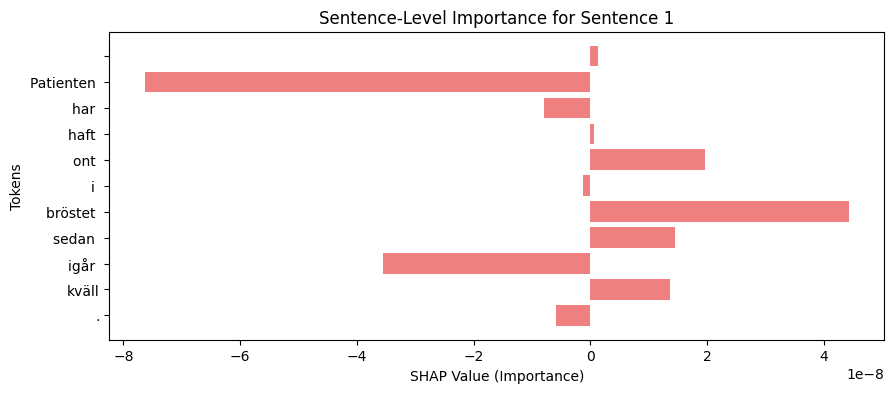


 Sentence 2: Kunden klagade på huvudvärk och illamående


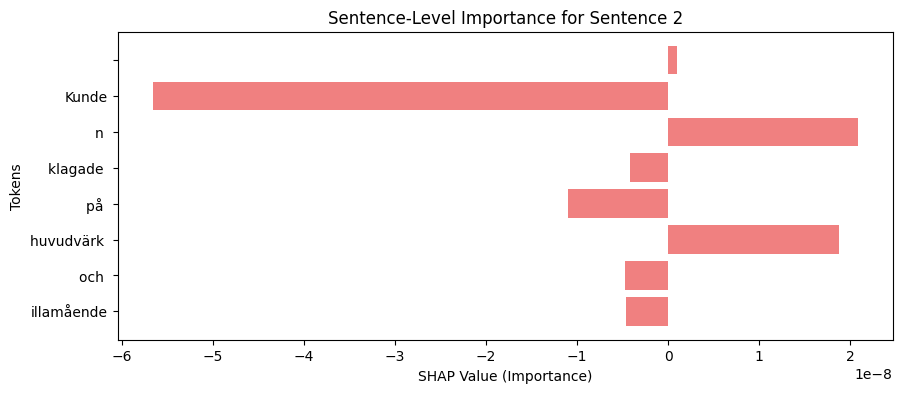

In [ ]:
import shap
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def model_wrapper(texts):
    """Wraps the model to take raw text, tokenize it, and return sentence-level probabilities."""
    
    # Convert numpy array to list if needed
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, max_length=512, padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits  # Shape: (batch_size, sequence_length, num_classes)
        
        # Collapse token-level logits to sentence-level (max over sequence)
        sentence_logits = logits.max(dim=1).values  # Shape: (batch_size, num_classes)
        
        # Convert logits to probabilities
        probs = F.softmax(sentence_logits, dim=-1)  # Shape: (batch_size, num_classes)
        
    # Return sentence-level probabilities (for multi-class classification)
    return probs.numpy()  # Shape: (batch_size, num_classes)

def shap_analysis(sentences):
    """Applies SHAP to visualize sentence-level importance for multiple sentences."""
    
    # Ensure sentences is a list
    if isinstance(sentences, str):
        sentences = [sentences]
    
    # ✅ FIX: Add a masker for text input
    explainer = shap.Explainer(model_wrapper, shap.maskers.Text(tokenizer))  
    shap_values = explainer(sentences)  # Explain multiple sentences

    for i, sentence in enumerate(sentences):
        print(f"\n Sentence {i+1}: {sentence}")
        shap.plots.text(shap_values[i])  # Show SHAP visualization per sentence

        # Extract SHAP values (sentence-level)
        sentence_importance = shap_values.values[i].sum(axis=-1)  # Sum across all classes for sentence-level importance
        tokens = shap_values.data[i]  # Extract tokens

        # Plot sentence-level importance
        plt.figure(figsize=(10, 4))
        plt.barh(tokens, sentence_importance, color="lightcoral")
        plt.xlabel("SHAP Value (Importance)")
        plt.ylabel("Tokens")
        plt.title(f"Sentence-Level Importance for Sentence {i+1}")
        plt.gca().invert_yaxis()  
        plt.show()

# === TEST THE FIX ===
test_sentences = [
    "Patienten har haft ont i bröstet sedan igår kväll.",
    "Kunden klagade på huvudvärk och illamående",
    "Han klagar på smärtor i ryggen och stelhet efter att ha suttit länge.",
]

shap_analysis(test_sentences)


## Results and Discussion

This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.

In [ ]:
# Always use comments in the code to document specific steps